In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn.functional as F
import tiktoken

from helper import text_to_token_ids, token_ids_to_text


In [3]:
tokenizer = tiktoken.get_encoding('gpt2')

special_tokens = {"<image>": tokenizer.n_vocab+1}
tokenizer_modified = tiktoken.Encoding(
    name="gpt2_with_image",
    pat_str=tokenizer._pat_str,
    mergeable_ranks=tokenizer._mergeable_ranks,
    special_tokens={**tokenizer._special_tokens, **special_tokens}
)

In [5]:
class OCR_dataset(Dataset):
    def __init__(self, dataset_file_name: str, files: list, tokenizer):
        super().__init__()
        self.master_files = dataset_file_name
        self.tokenizer = tokenizer
        self.files = files  # e.g., ['1_hello.jpg', '2_world.jpg']
        
        self.transform = T.Compose([
            T.ToTensor(),                            
            T.Resize((1024, 1024)),                   
        ])
    
    def __getitem__(self, index):
        filename = self.files[index]
        
        # Extract text from filename: "1_hello.jpg" -> "hello"
        text = filename.split('_', 1)[1].split('.jpg')[0]  # FIXED: Keep underscores in label
        
        # Load image
        path = os.path.join(self.master_files, filename)
        image_np = plt.imread(path)
        image = self.transform(image_np)
        
        # FIXED: Add <image> token to input
        input_text = f"<image>\n{text}"
        input_ids = text_to_token_ids(input_text, self.tokenizer)
        
        # FIXED: Create targets for training (same as input for OCR)
        target_ids = input_ids.clone()
        
        return input_ids, target_ids, image

    def __len__(self):
        return len(self.files)

dataset = OCR_dataset(dataset_file_name = 'dataset', 
                      files = os.listdir('dataset'), 
                      tokenizer = tokenizer_modified)
input_ids, target_ids, image = next(iter(dataset))

In [6]:
input_ids

tensor([[50258,   198,    13,   679,   550,   279,   198,   793,  6676,   289,
           198,   271,  2426,   198,    11, 19233]])

In [7]:
target_ids

tensor([[50258,   198,    13,   679,   550,   279,   198,   793,  6676,   289,
           198,   271,  2426,   198,    11, 19233]])

In [9]:
image.shape

torch.Size([3, 1024, 1024])

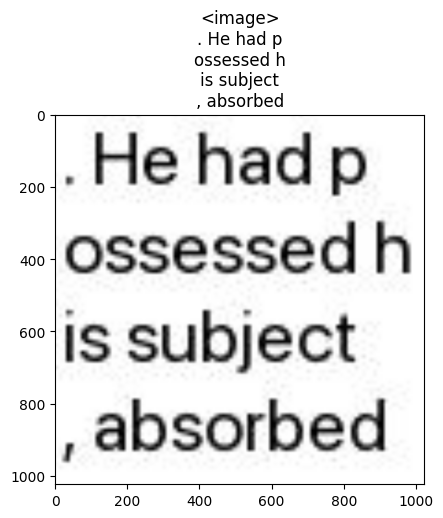

In [10]:
plt.imshow(image.permute(1,2,0).detach().numpy())
plt.title(token_ids_to_text(input_ids, tokenizer_modified))
plt.show()

In [11]:
def ocr_collate(batch):

    input_ids_list, target_ids_list, images_list = zip(*batch)

    max_len = max(x.shape[1] for x in input_ids_list)
    
    padded_inputs = []
    padded_targets = []
    
    for inp, tgt in zip(input_ids_list, target_ids_list):
        seq_len = inp.shape[1]
        pad_amount = max_len - seq_len
        
        # Pad inputs with <|endoftext|> token (50256)
        padded_inp = F.pad(inp, (0, pad_amount), value=50256)
        padded_inputs.append(padded_inp)
        
        # Pad targets with -100 (ignored in CrossEntropyLoss)
        padded_tgt = F.pad(tgt, (0, pad_amount), value=-100)
        padded_targets.append(padded_tgt)
        
    
    padded_inputs = torch.cat(padded_inputs, dim=0)
    padded_targets = torch.cat(padded_targets, dim=0)
    images = torch.stack(images_list, dim=0)
    
    return {
        'input_ids': padded_inputs,       # [batch, seq_len]
        'target_ids': padded_targets,     # [batch, seq_len]
        'images': images                   # [batch, 3, 1024, 1024]
    }

In [12]:
files = os.listdir('dataset')
l = len(files)

train_frac = 0.8
test_frac  = 0.1

train_pos = int(l * train_frac)
test_pos  = int(l * test_frac)

train_files = files[: train_pos]
test_files = files[train_pos : train_pos + test_pos]
val_files  = files[train_pos + test_pos : ]

In [13]:
len(train_files), len(test_files), len(val_files)

(409, 51, 52)

In [14]:
batch_size = 8

train_dl = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = train_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=True,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

test_dl  = DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = test_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

val_dl  =  DataLoader(
           dataset=OCR_dataset(
               dataset_file_name = 'dataset',
               files = val_files,
               tokenizer = tokenizer_modified
               ),
           batch_size=batch_size,
           shuffle=False,
           collate_fn=ocr_collate,
           pin_memory=True,
           drop_last = True
       )

a = next(iter(train_dl))


/Users/mohamedmafaz/Desktop/OCR Model/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [25]:
for i in range(2):
    print(
        token_ids_to_text(a['input_ids'][i], tokenizer_modified)
    )
    print('-'*10)

<image>
 thing. Th
e next gre
atest thin
g was to s<|endoftext|><|endoftext|><|endoftext|>
----------
<image>
 that he w
as superb.


"I was g
lad at fir<|endoftext|><|endoftext|>
----------


In [44]:
for i in range(2):
    target_id = a['target_ids'][i]
    idx_100 = sum(target_id != -100)

    print(
        token_ids_to_text(a['target_ids'][i][:idx_100], tokenizer_modified)
    )
    print('-'*10)

<image>
 thing. Th
e next gre
atest thin
g was to s
----------
<image>
 that he w
as superb.


"I was g
lad at fir
----------
